In [8]:
import os
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import scipy.signal as sg
from sklearn.decomposition import SparsePCA
from scipy import stats
import timeit
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd
from datetime import datetime
import pytz
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt

import itertools

In [69]:
# Function to calculate the Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in km
    R = 6371
    # Convert degrees to radians
    lat1_rad = np.radians(lat1)
    lat2_rad = np.radians(lat2)
    lon1_rad = np.radians(lon1)
    lon2_rad = np.radians(lon2)
    # Compute differences in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

# Compute the distance of each Surfline location to each station
def closest_station(surfline_df, station_df):
    closest_stations = []
    for index, surfline_row in surfline_df.iterrows():
        min_distance = np.inf
        closest_station = None
        for _, station_row in station_df.iterrows():
            distance = haversine(surfline_row['lat'], surfline_row['lon'],
                                 station_row['lat'], station_row['lon'])
            if distance < min_distance:
                min_distance = distance
                closest_station = station_row['station']
        closest_stations.append(closest_station)
    return closest_stations

def round_to_half_hour(ts):
    # Extract minutes
    minute = ts.minute
    # Round down if less than 15, else round up to 30 if less than 45, else round to 60 (which will roll over to the next hour)
    if minute < 15 or minute >= 45:
        new_minute = 0
    else:
        new_minute = 30
    # replace minute and seconds with new minute and 0 seconds
    return ts.replace(minute=new_minute, second=0)

In [95]:
fog_results = pd.read_csv('/home/smmrrr/Fog_Imaging_Project/Fog_Project_Code/datasets/three_model_classifications.csv')

In [96]:
fog_results['time_pst'] = pd.to_datetime(fog_results['time_pst'])
fog_results['date'] = fog_results['time_pst'].dt.date
# Create a mapping dictionary for the 'site' to 'rf_pred_staggered_site' values
site_to_staggered = {
    'Agate Beach': 0.2,
    'Beverly': 0.0,  # Beverly camera discontinued in 2023
    'Cannon Beach': 0.4,
    'Lincoln City': 0.6,
    'Otter Rock': 0.8,
    'Pacific City': 1.0
}
# mask = fog_results['rf_pred'] == 1
fog_results.loc[fog_results['rf_pred'] == 1
                , 'rf_pred_staggered_site'] = fog_results.loc[fog_results['rf_pred'] == 1
                                                , 'site'].map(site_to_staggered)

fog_results.loc[fog_results['logit_pred'] == 1
                , 'logit_pred_staggered_site'] = fog_results.loc[fog_results['logit_pred'] == 1
                                                , 'site'].map(site_to_staggered)

fog_results.loc[fog_results['cnn_pred'] == 1
                , 'cnn_pred_staggered_site'] = fog_results.loc[fog_results['cnn_pred'] == 1
                                                , 'site'].map(site_to_staggered)

fog_results

,photo,Label,site,Label_train,rf_pred,logit_pred,cnn_pred,year,month,day,hour,minute,time_pst,time_delta,td_count,date,rf_pred_staggered_site,logit_pred_staggered_site,cnn_pred_staggered_site
0,2022_07-04.0900_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,0,2022,7,4,7,0,2022-07-04 07:00:00-07:00,NaN,NaN,2022-07-04,NaN,NaN,NaN
1,2022_07-04.0930_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,0,2022,7,4,7,30,2022-07-04 07:30:00-07:00,0 days 00:30:00,28066.0,2022-07-04,NaN,NaN,NaN
2,2022_07-04.1000_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,0,2022,7,4,8,0,2022-07-04 08:00:00-07:00,0 days 00:30:00,28066.0,2022-07-04,NaN,NaN,NaN
3,2022_07-04.1030_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,0,2022,7,4,8,30,2022-07-04 08:30:00-07:00,0 days 00:30:00,28066.0,2022-07-04,NaN,NaN,NaN
4,2022_07-04.1100_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,0,2022,7,4,9,0,2022-07-04 09:00:00-07:00,0 days 00:30:00,28066.0,2022-07-04,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29867,2023_09-30.1900_pacificcityor.jpg,not labeled,Pacific City,NaN,0,0,0,2023,9,30,17,0,2023-09-30 17:00:00-07:00,0 days 00:30:00,28066.0,2023-09-30,NaN,NaN,NaN
29868,2023_09-30.2000_pacificcityor.jpg,not labeled,Pacific City,NaN,0,0,0,2023,9,30,18,0,2023-09-30 18:00:00-07:00,0 days 01:00:00,582.0,2023-09-30,NaN,NaN,NaN
29869,2023_09-30.2030_pacificcityor.jpg,not labeled,Pacific City,NaN,0,0,0,2023,9,30,18,30,2023-09-30 18:30:00-07:00,0 days 00:30:00,28066.0,2023-09-30,NaN,NaN,NaN
29870,2023_09-30.2100_pacificcityor.jpg,not_foggy,Pacific City,0.0,0,0,0,2023,9,30,19,0,2023-09-30 19:00:00-07:00,0 days 00:30:00,28066.0,2023-09-30,NaN,NaN,NaN


In [97]:
###read in weather data
surfline_location = pd.DataFrame({
'site': ['Agate Beach', 'Cannon Beach', 'Otter Rock'
              , 'Pacific City', 'Lincoln City', 'Beverly'
             ]
 , 'lat': [44.66, 45.90, 44.74, 45.22, 44.98, 44.72]
    ,'lon': [-124.06,
 -123.97,
-124.06,
-123.97,
-124.02,
-124.06
]
})

asos = pd.read_csv('/home/smmrrr/Fog_Imaging_Project/Fog_Project_Code/datasets/oregon_coast_weather_data_2022_2023.csv')
print(asos.columns)

stations = asos[['station','lon', 'lat']].drop_duplicates()
surfline_location['station'] = closest_station(surfline_location, stations)

Index(['station', 'valid', 'lon', 'lat', 'elevation', 'tmpf', 'dwpf', 'relh',
       'drct', 'sknt', 'p01i', 'alti', 'mslp', 'vsby', 'gust', 'skyc1',
       'skyc2', 'skyc3', 'skyc4', 'skyl1', 'skyl2', 'skyl3', 'skyl4',
       'wxcodes', 'ice_accretion_1hr', 'ice_accretion_3hr',
       'ice_accretion_6hr', 'peak_wind_gust', 'peak_wind_drct',
       'peak_wind_time', 'feel', 'metar', 'snowdepth'],
      dtype='object')


In [98]:
fog_results=fog_results.merge(surfline_location, on = 'site')

In [103]:
asos.dtypes

station                      object
valid                datetime64[ns]
lon                         float64
lat                         float64
elevation                   float64
tmpf                        float64
dwpf                        float64
relh                        float64
drct                        float64
sknt                        float64
p01i                        float64
alti                        float64
mslp                        float64
vsby                        float64
gust                        float64
skyc1                        object
skyc2                        object
skyc3                        object
skyc4                       float64
skyl1                       float64
skyl2                       float64
skyl3                       float64
skyl4                       float64
wxcodes                      object
ice_accretion_1hr           float64
ice_accretion_3hr           float64
ice_accretion_6hr           float64
peak_wind_gust              

In [105]:
asos['valid'] = pd.to_datetime(asos['valid'])
asos['valid_round'] = asos['valid'].apply(round_to_half_hour)
original_timezone =pytz.timezone('US/Pacific')
asos['time_pst'] = asos['valid_round'].dt.tz_localize(original_timezone,ambiguous='NaT')

In [71]:
# asos.loc[asos['station']== 'ONP']
asos['valid_round'].dt.minute.value_counts()

0     106097
30     97713
Name: valid_round, dtype: int64

In [109]:
half_hour_met = asos.groupby(['station','lon', 'lat', 'elevation'
              ,'time_pst'])[['tmpf','relh','drct', 'sknt','vsby']].mean().reset_index()

In [113]:
fog_results=fog_results.merge(half_hour_met, on = ['station', 'time_pst'], how = 'left')

In [111]:
len(fog_results)

29872

In [4]:
fog_results.loc[fog_results['year']==2022].describe()

,Label_train,rf_pred,logit_pred,cnn_pred,year,month,day,hour,minute,td_count
count,3488.000000,12047.000000,12047.000000,12047.000000,12047.0,12047.000000,12047.000000,12047.000000,12047.000000,11861.000000
mean,0.164851,0.162530,0.163360,0.160538,2022.0,7.950942,16.343073,12.988960,15.003735,26891.692437
std,0.371099,0.368952,0.369709,0.367119,0.0,0.785474,8.521555,3.741075,15.000622,5557.460730
min,0.000000,0.000000,0.000000,0.000000,2022.0,7.000000,1.000000,7.000000,0.000000,27.000000
25%,0.000000,0.000000,0.000000,0.000000,2022.0,7.000000,9.000000,10.000000,0.000000,28066.000000
50%,0.000000,0.000000,0.000000,0.000000,2022.0,8.000000,16.000000,13.000000,30.000000,28066.000000
75%,0.000000,0.000000,0.000000,0.000000,2022.0,9.000000,24.000000,16.000000,30.000000,28066.000000
max,1.000000,1.000000,1.000000,1.000000,2022.0,9.000000,31.000000,19.000000,30.000000,28066.000000


In [83]:
# fog_results[['rf_pred','rf_pred_staggered_site']].value_counts()
# fog_results[['rf_pred']].value_counts()
tt = fog_results.groupby(['site', 'year'])['date'].agg(['min','max','count']).reset_index()
tt['test']=tt['max']-tt['min']
# tt

[Text(0, 0.5, '')]

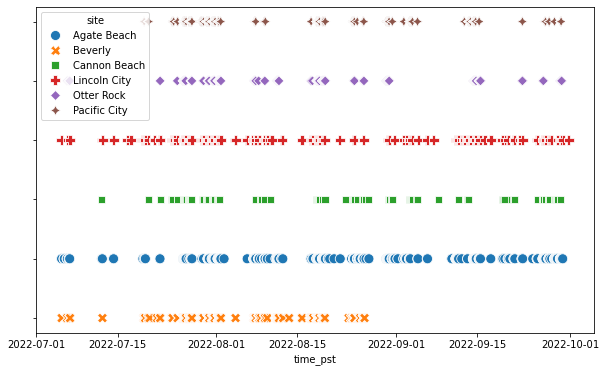

In [114]:
from matplotlib.dates import DateFormatter, HourLocator,DayLocator
from matplotlib.ticker import MaxNLocator
plt.figure(figsize=(10,6))

sp = sns.scatterplot(data = fog_results.loc[(fog_results['year']==2022)
                                            # &(fog_results['month']==7)
                                   # &(fog_results['day']==12)
                                      ],
            x = 'time_pst', hue = 'site', style = 'site', y = 'rf_pred_staggered_site', s = 100)

# Make the y-axis tick labels blank
sp.set(yticklabels=[])

# You can also remove the y-axis label if desired using the method below
sp.set(ylabel=None)

# sp.xaxis.set_major_locator(MaxNLocator(nbins=9)) # Ticks every 6 hours
# sp.xaxis.set_major_formatter(DateFormatter('%D'))
# plt.setp(sp.get_xticklabels(), rotation=45, ha='right') # Set the rotation for the tick labels



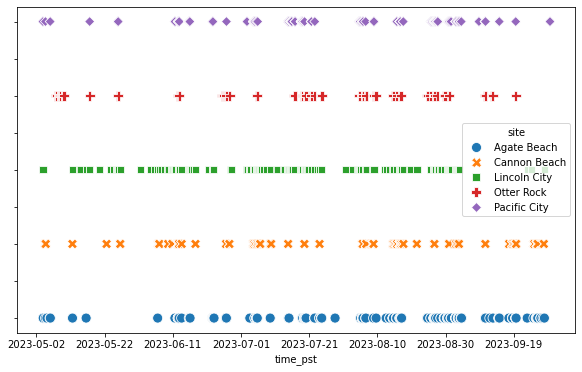

In [115]:
from matplotlib.dates import DateFormatter, HourLocator,DayLocator
from matplotlib.ticker import MaxNLocator
plt.figure(figsize=(10,6))

sp = sns.scatterplot(data = fog_results.loc[(fog_results['year']==2023)
                                            # &(fog_results['month']==7)
                                   # &(fog_results['day']==12)
                                      ],
            x = 'time_pst', hue = 'site', style = 'site', y = 'rf_pred_staggered_site', s = 100)

# Make the y-axis tick labels blank
sp.set(yticklabels=[])

# You can also remove the y-axis label if desired using the method below
sp.set(ylabel=None)

sp.xaxis.set_major_locator(MaxNLocator(nbins=9)) # Ticks every 6 hours
# sp.xaxis.set_major_formatter(DateFormatter('%D'))
# plt.setp(sp.get_xticklabels(), rotation=45, ha='right') # Set the rotation for the tick labels



In [6]:
fog_results.site.unique()

array(['Agate Beach', 'Beverly', 'Cannon Beach', 'Lincoln City',
       'Otter Rock', 'Pacific City'], dtype=object)

In [ ]:
fog_results

In [50]:
fog_results

,photo,Label,site,Label_train,rf_pred,logit_pred,cnn_pred,year,month,day,hour,minute,time_pst,time_delta,td_count,rf_pred_staggered_site
0,2022_07-04.0900_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,0,2022,7,4,7,0,2022-07-04 07:00:00-07:00,NaN,NaN,NaN
1,2022_07-04.0930_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,0,2022,7,4,7,30,2022-07-04 07:30:00-07:00,0 days 00:30:00,28066.0,NaN
2,2022_07-04.1000_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,0,2022,7,4,8,0,2022-07-04 08:00:00-07:00,0 days 00:30:00,28066.0,NaN
3,2022_07-04.1030_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,0,2022,7,4,8,30,2022-07-04 08:30:00-07:00,0 days 00:30:00,28066.0,NaN
4,2022_07-04.1100_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,0,2022,7,4,9,0,2022-07-04 09:00:00-07:00,0 days 00:30:00,28066.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29867,2023_09-30.1900_pacificcityor.jpg,not labeled,Pacific City,NaN,0,0,0,2023,9,30,17,0,2023-09-30 17:00:00-07:00,0 days 00:30:00,28066.0,NaN
29868,2023_09-30.2000_pacificcityor.jpg,not labeled,Pacific City,NaN,0,0,0,2023,9,30,18,0,2023-09-30 18:00:00-07:00,0 days 01:00:00,582.0,NaN
29869,2023_09-30.2030_pacificcityor.jpg,not labeled,Pacific City,NaN,0,0,0,2023,9,30,18,30,2023-09-30 18:30:00-07:00,0 days 00:30:00,28066.0,NaN
29870,2023_09-30.2100_pacificcityor.jpg,not_foggy,Pacific City,0.0,0,0,0,2023,9,30,19,0,2023-09-30 19:00:00-07:00,0 days 00:30:00,28066.0,NaN


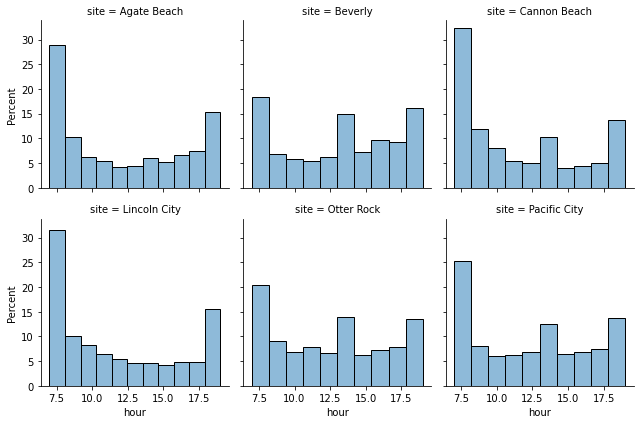

In [116]:
##most frequent fog hours per day
# sns.histplot(data = fog_results.loc[fog_results['rf_pred']==1]
#             ,x = 'hour',  hue = 'site')
g = sns.FacetGrid(data=fog_results.loc[fog_results['rf_pred'] == 1]
              ,col='site', col_wrap=3, sharey=True)
g.map_dataframe(sns.histplot, x = 'hour', hue = 'site',stat="percent")
# sns.histplot(data=fog_results.loc[fog_results['rf_pred'] == 1]
#              , x='hour', hue='site', col='site', multiple='stack', col_wrap=3)

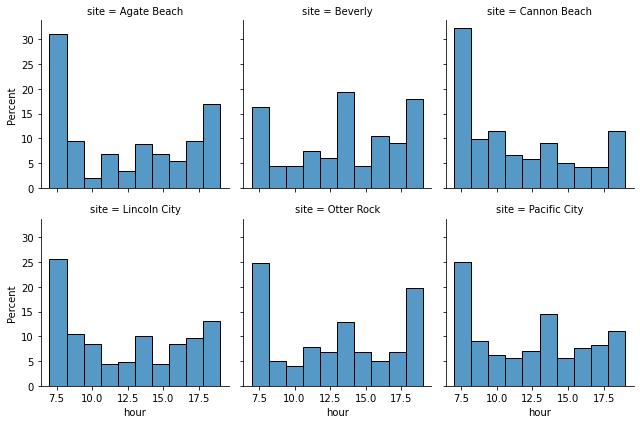

In [118]:
g = sns.FacetGrid(data=fog_results.loc[fog_results['Label_train'] == 1]
              ,col='site', col_wrap=3, sharey=True)
g.map(sns.histplot, 'hour', stat="percent", bins = 10)

In [119]:
##aggregate by day, have number of foggy hours per day
day_sum = fog_results.groupby(['site','date', 'year', 'month'])['rf_pred'].sum().reset_index()
day_sum['fog_day']=0
day_sum.loc[day_sum['rf_pred']>0, 'fog_day'] = 1

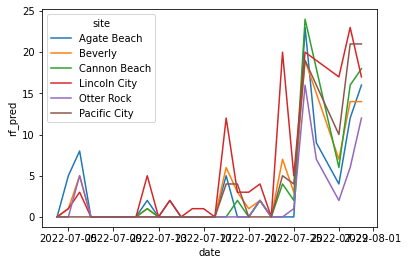

In [120]:
sp = sns.lineplot(day_sum.loc[(day_sum['year']==2022)
                    &(day_sum['month']==7)
                        ], x = 'date', y = 'rf_pred',hue = 'site')

# plt.setp(sp.get_xticklabels(), rotation=45, ha='right') # Set the rotation for the tick labels


In [121]:
### % of times that sites experienced fog at the same time
compare_cooccure = fog_results.pivot(index = 'time_pst', columns = 'site', values = 'rf_pred').reset_index()

In [122]:
compare_cooccure.columns

Index(['time_pst', 'Agate Beach', 'Beverly', 'Cannon Beach', 'Lincoln City',
       'Otter Rock', 'Pacific City'],
      dtype='object', name='site')

In [123]:
compare_cooccure.describe() 

 # Calculate the percentage of time each pair of variables both equal 1
matrix_df = pd.DataFrame(index=fog_results.site.unique()
                         , columns=fog_results.site.unique())

# Generate all unique pairs of columns
for pair in itertools.permutations(compare_cooccure[['Agate Beach', 'Beverly'
           , 'Cannon Beach', 'Lincoln City',
       'Otter Rock', 'Pacific City']], 2):
    # Calculate the mean where both columns in the pair are 1
    matrix_df.at[pair[0], pair[1]]  = (compare_cooccure.loc[compare_cooccure[pair[0]] == 1, list(pair)].prod(axis=1) == 1).mean() 

matrix_df



,Agate Beach,Beverly,Cannon Beach,Lincoln City,Otter Rock,Pacific City
Agate Beach,NaN,0.899338,0.33245,0.598675,0.529801,0.350993
Beverly,0.738462,NaN,0.446154,0.623077,0.580769,0.519231
Cannon Beach,0.546798,0.834975,NaN,0.615764,0.389163,0.428571
Lincoln City,0.529095,0.892241,0.289871,NaN,0.380388,0.382543
Otter Rock,0.668151,0.982183,0.267261,0.563474,NaN,0.4098
Pacific City,0.615063,0.905858,0.376569,0.753138,0.512552,NaN


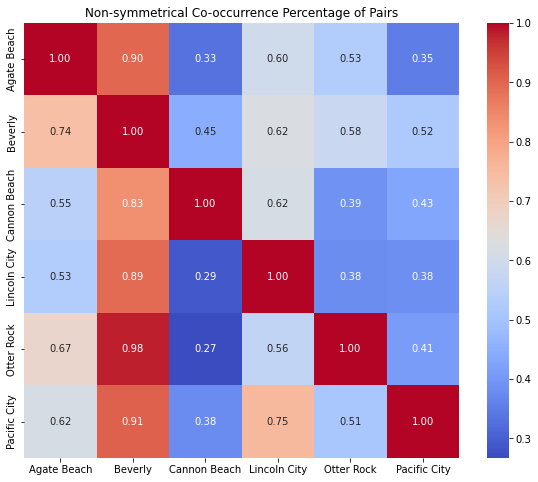

In [124]:
matrix_df.fillna(1, inplace=True)

# Now, use seaborn's heatmap function to plot this matrix
plt.figure(figsize=(10, 8))
sns.heatmap(matrix_df, annot=True, fmt=".2f", cmap="coolwarm", square=True, mask=matrix_df == 0)  # Annotate each cell with the percentage values
plt.title("Non-symmetrical Co-occurrence Percentage of Pairs")
plt.show()


In [125]:
compare_day.columns

Index(['Agate Beach', 'Beverly', 'Cannon Beach', 'Lincoln City', 'Otter Rock',
       'Pacific City'],
      dtype='object', name='site')

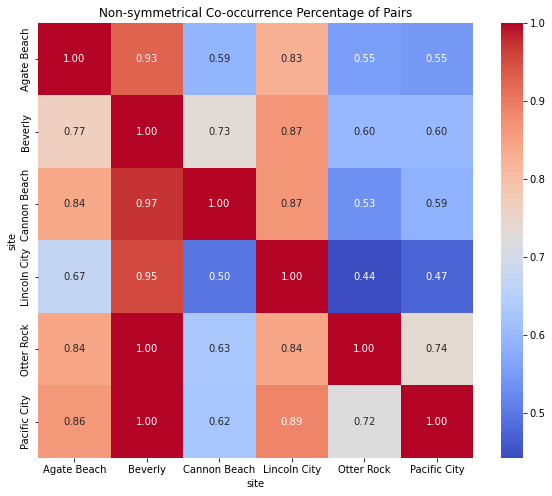

In [126]:

compare_day = day_sum.pivot(index = 'date'
                                 , columns = 'site'
                                 , values = 'fog_day')
 # Calculate the percentage of time each pair of variables both equal 1
day_matrix_df = pd.DataFrame(index=compare_day.columns
                         , columns=compare_day.columns)

# Generate all unique pairs of columns
for pair in itertools.permutations(compare_day[['Agate Beach', 'Beverly'
           , 'Cannon Beach', 'Lincoln City',
       'Otter Rock', 'Pacific City']], 2):
    # Calculate the mean where both columns in the pair are 1
    day_matrix_df.at[pair[0], pair[1]]  = (compare_day.loc[compare_day[pair[0]] == 1, list(pair)].prod(axis=1) == 1).mean() 

# day_matrix_df
day_matrix_df.fillna(1, inplace=True)

# Now, use seaborn's heatmap function to plot this matrix
plt.figure(figsize=(10, 8))
sns.heatmap(day_matrix_df, annot=True, fmt=".2f", cmap="coolwarm", square=True, mask=matrix_df == 0)  # Annotate each cell with the percentage values
plt.title("Non-symmetrical Co-occurrence Percentage of Pairs")
plt.show()


In [35]:
day_sum

,site,date,year,month,rf_pred,fog_day
0,Agate Beach,2022-07-04,2022,7,0,0
1,Agate Beach,2022-07-05,2022,7,5,1
2,Agate Beach,2022-07-06,2022,7,8,1
3,Agate Beach,2022-07-07,2022,7,0,0
4,Agate Beach,2022-07-08,2022,7,0,0
...,...,...,...,...,...,...
1191,Pacific City,2023-09-26,2023,9,0,0
1192,Pacific City,2023-09-27,2023,9,0,0
1193,Pacific City,2023-09-28,2023,9,0,0
1194,Pacific City,2023-09-29,2023,9,0,0


In [ ]:
###lag statistical measures



Index(['station', 'valid', 'lon', 'lat', 'elevation', 'tmpf', 'dwpf', 'relh',
       'drct', 'sknt', 'p01i', 'alti', 'mslp', 'vsby', 'gust', 'skyc1',
       'skyc2', 'skyc3', 'skyc4', 'skyl1', 'skyl2', 'skyl3', 'skyl4',
       'wxcodes', 'ice_accretion_1hr', 'ice_accretion_3hr',
       'ice_accretion_6hr', 'peak_wind_gust', 'peak_wind_drct',
       'peak_wind_time', 'feel', 'metar', 'snowdepth'],
      dtype='object')

In [127]:
filtered_data = fog_results.loc[fog_results['year']==2023]

In [131]:
# ## reproduce visibility / relh
# filtered_data['vsby'] = filtered_data['vsby']/1.60934
# import plotly.express as px

# # Create the main line plot for Relative Humidity
# fig2 = px.line(
#     filtered_data,
#     x='time_pst',
#     y='vsby',
#     labels={'vsby': 'ASOS Visbility'},
#     color_discrete_sequence=['paleturquoise']
# )
# fig2.add_scatter(
# x=filtered_data['time_pst'],
# y=filtered_data['rf_pred'],
# mode='markers',
# name='Random Forest Foggy Classification',
# marker=dict(color='purple', size=10)
# )
# fig2.add_hline(y=1, line=dict(color='black', dash='dash'))

# fig2.update_layout(
#     legend=dict(
#         y=1,  # y=1 places the legend at the top
#         x=0.5,  # x=0.5 centers the legend
#         xanchor='center',  # 'center' means the center of the legend is at x position
#         yanchor='bottom',  # 'bottom' means the bottom of the legend is at the y position
#         orientation='h'  # Horizontal orientation
#     ),
#     # ... other layout properties
# )
# # Update layout of the fig2ure
# fig2.update_layout(
#     xaxis_title='Date (hourly)',
#     yaxis_title='Visbility (kilometers)',
#     # yaxis_tickformat='.0%',  # Add this line to format the y-axis ticks as percentages
#     xaxis_tickangle=-45,
#     legend_title_text='Model',
#     legend_font_size=14,
#     height=500,
# )


In [ ]:
## plot temperature

In [ ]:
## plot average windspeed

In [ ]:
## plot average wind direction by ASOS site